# I-94 Traffic Visualization & Analysis
* With this notebook I'm looking to practice Data Analysis through visualizing the data
* I'm want to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc.
    * example: We may find out that the traffic is usually heavier in the summer or when it snows.

# Data: [I-94 Interstate highway traffic](https://en.wikipedia.org/wiki/Interstate_94)
* Source: [https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

## Column / header info
* **holiday** Categorical US National holidays plus regional holiday, Minnesota State Fair
* **temp**:  Numeric Average temp in kelvin
* **rain_1h**:  Numeric Amount in mm of rain that occurred in the hour
* **snow_1h**:  Numeric Amount in mm of snow that occurred in the hour
* **clouds_all**:  Numeric Percentage of cloud cover
* **weather_main**:  Categorical Short textual description of the current weather
* **weather_description**:  Categorical Longer textual description of the current weather
* **date_time**:  DateTime Hour of the data collected in local CST time
* **traffic_volume**:  Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [1]:
import pandas as pd

In [2]:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

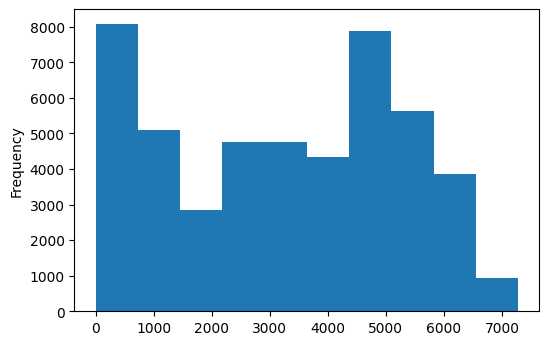

In [5]:
traffic['traffic_volume'].plot.hist()
plt.show()

In [6]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

## traffic_volume Observations
* Data ranges from 0 to ~7300
* histogram suggests that the data could be broken down further by time of day
* what happened when traffic was 0?
* what happened when traffic averaged 5000?



In [7]:
# converting data's date_time to datetime object
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

In [8]:
traffic['date_time'].dt.hour

0         9
1        10
2        11
3        12
4        13
         ..
48199    19
48200    20
48201    21
48202    22
48203    23
Name: date_time, Length: 48204, dtype: int64

In [9]:
pd.value_counts(traffic['date_time'].dt.hour).sort_index()

0     2037
1     2049
2     2019
3     2025
4     2091
5     2063
6     2087
7     2079
8     2080
9     2018
10    2078
11    1952
12    1955
13    1905
14    1969
15    1934
16    1988
17    1933
18    1986
19    1961
20    1979
21    1982
22    1994
23    2040
Name: date_time, dtype: int64

It's strange that there is a dip in traffic recordings datapoints from ~11am to 10pm.

In [10]:
is_day_traffic = (traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)
is_night_traffic = (traffic['date_time'].dt.hour < 7) | (19 <= traffic['date_time'].dt.hour)

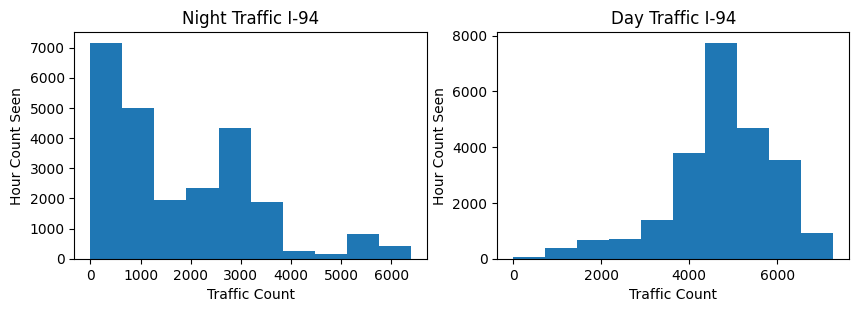

In [11]:
plt.figure(figsize=(10,3))
plt.ylim(0,9000)
plt.ylabel("Hour Count")

plt.subplot(1,2, 1)
traffic.loc[is_night_traffic, 'traffic_volume'].plot.hist()
plt.title("Night Traffic I-94")
plt.ylabel("Hour Count Seen")
plt.xlabel("Traffic Count")

plt.subplot(1,2, 2)
traffic.loc[is_day_traffic, 'traffic_volume'].plot.hist()
plt.title("Day Traffic I-94")
plt.ylabel("Hour Count Seen")
plt.xlabel("Traffic Count")

plt.show()

### impressions
* During Night Traffic is usually less than 2000.
* Night Traffic can probably be broken down further to identify the right side of the histogram

* Day traffic averages ~4k with an spike at 5k.
* Day traffic can probably be broken down further to identify morning & evening rush hours.

In [12]:
# traffic.loc[is_night_traffic, 'traffic_volume'].describe()

In [13]:
traffic['month'] = traffic['date_time'].dt.month

day = traffic[is_day_traffic]
night = traffic[is_night_traffic]

by_month = day.groupby('month').mean()
by_month['traffic_volume']


month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

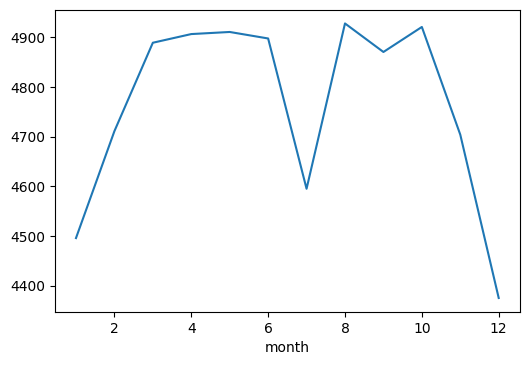

In [14]:
by_month['traffic_volume'].plot.line()
plt.show()

There is an odd dropoff in July for daytime traffic.
Traffic is less during the winter months.

In [15]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

<ipython-input-15-e4e897828b56>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

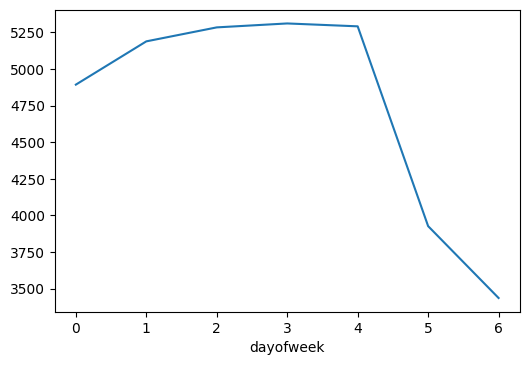

In [16]:
by_dayofweek['traffic_volume'].plot.line()
plt.show()

In [17]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


<ipython-input-17-4244afafd4b2>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



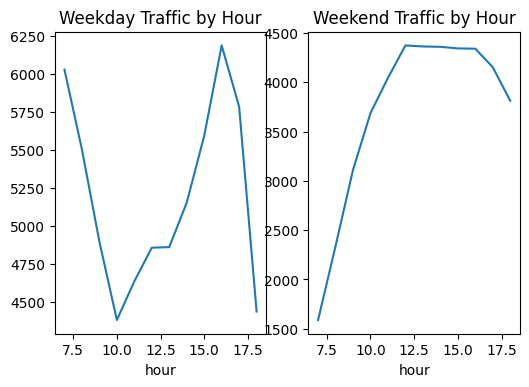

In [18]:
plt.figure()

plt.subplot(1,2,1)
by_hour_business['traffic_volume'].plot.line()
plt.title("Weekday Traffic by Hour")

plt.subplot(1,2,2)
by_hour_weekend['traffic_volume'].plot.line()
plt.title("Weekend Traffic by Hour")

plt.show()

In [19]:
# weather_col = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

(230.0, 320.0)

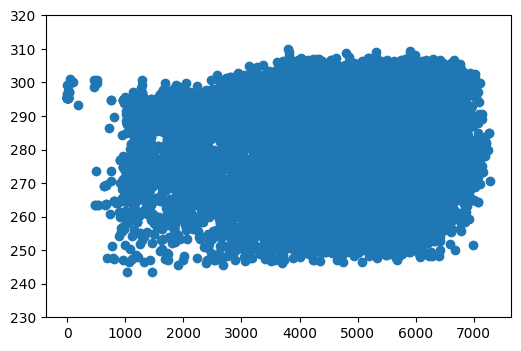

In [20]:
plt.scatter(x=day['traffic_volume'], y=day['temp'])
plt.ylim(230, 320)

Correlation between temp and traffic volume is low.

In [21]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_description = day.groupby('weather_description').mean()

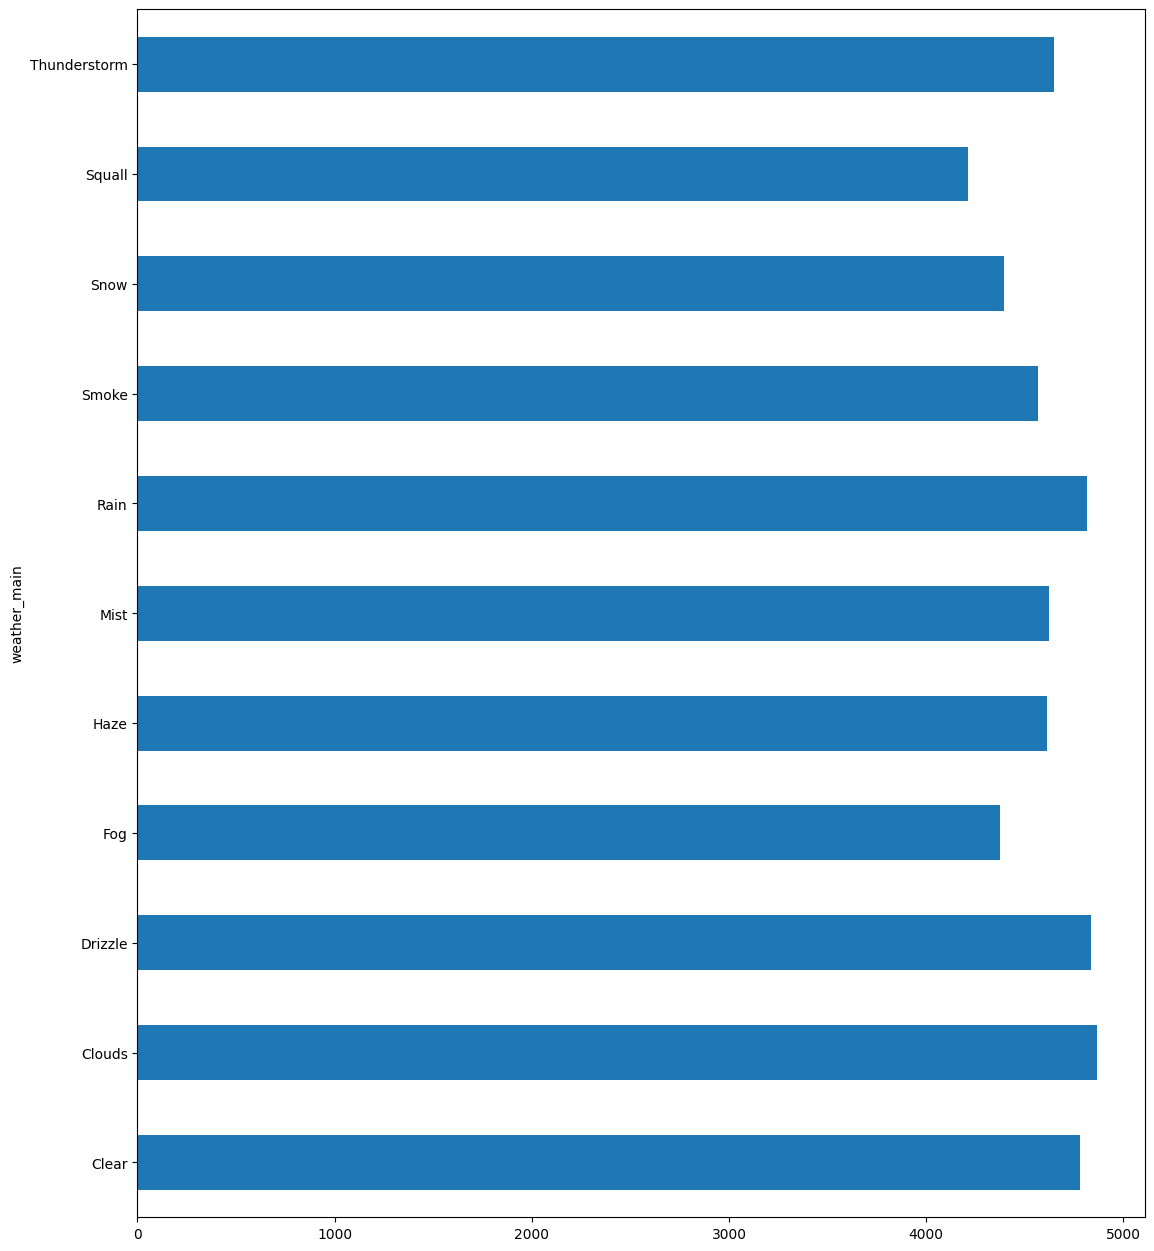

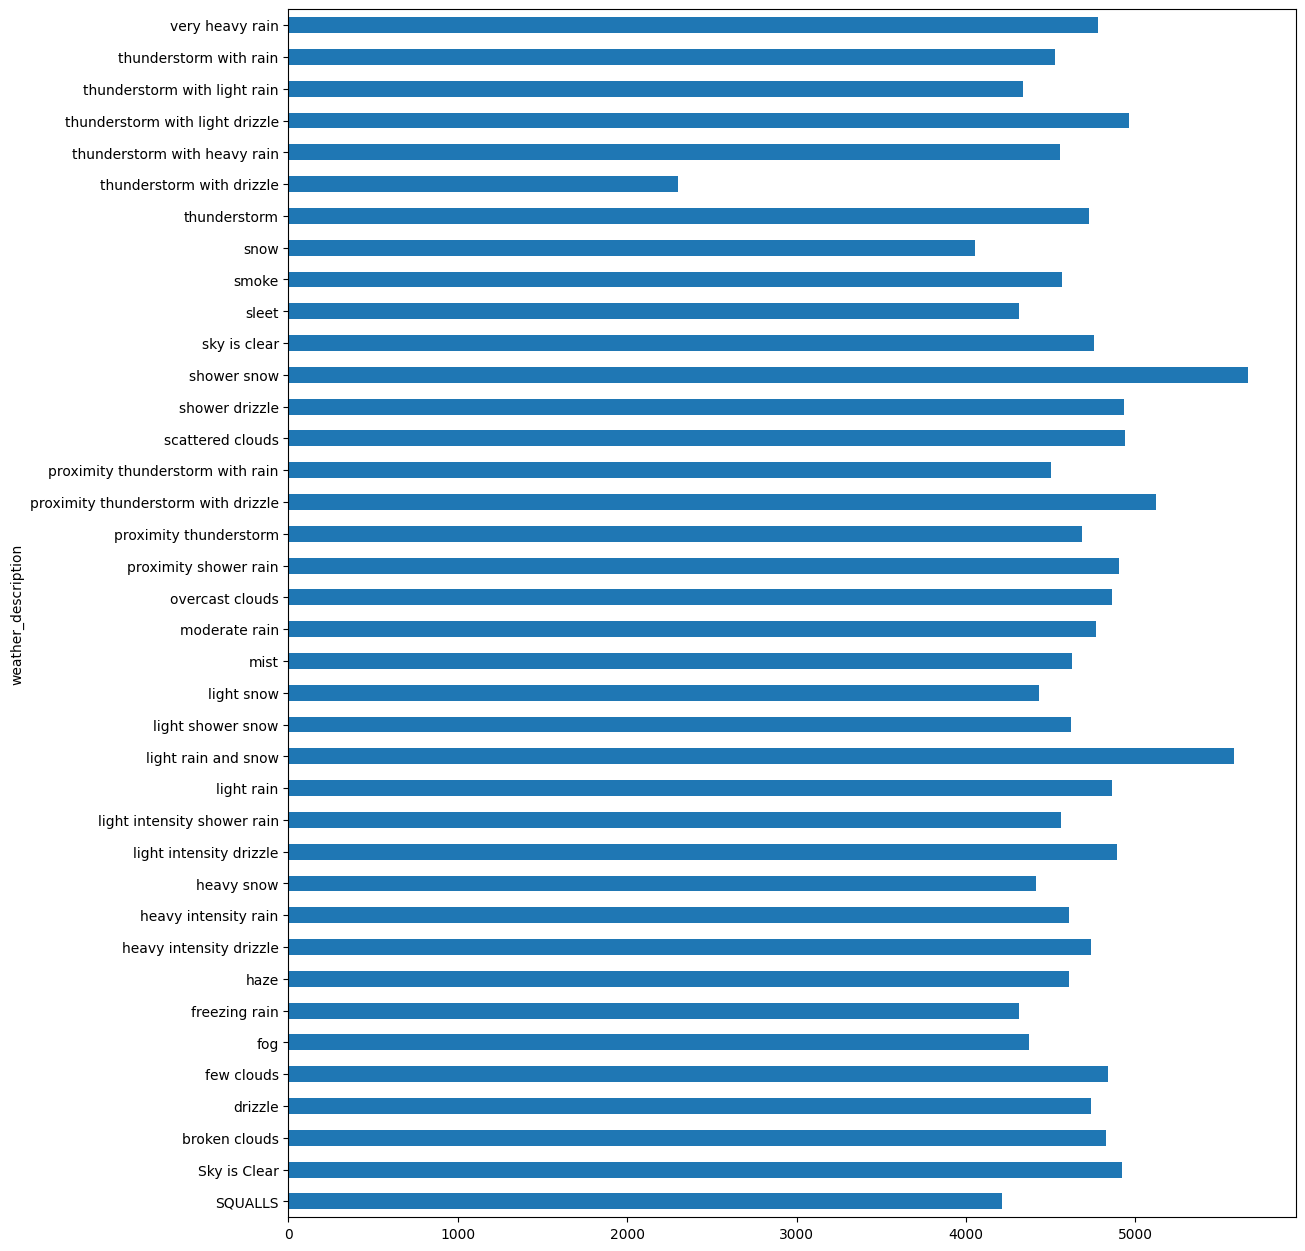

In [22]:
by_weather_main['traffic_volume'].plot.barh(figsize=(13,16))
plt.show()

plt.figure(figsize=(13,16))
by_weather_description['traffic_volume'].plot.barh()
plt.yticks
plt.show()

"light shower snow" and "shower snow" and "proximity thunderstorm with rain" are major indicators of traffic.

## Insights
* Time
    * Traffic is heavier on weekdays
    * Traffic Volume goes down during the winter months
    * on Business Days, Traffic is the worst around 7 & 5
* Weather: Traffic is worst(in order) during: 
    * shower snow
    * light shower and snow
    * proximity thunderstorm with rain